In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import aplpy as apl
from matplotlib.colors import LogNorm

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
vlt1 = '/Users/yaolun/bhr71/data/photometry/VLT/VLT1.fits'
vlt2 = '/Users/yaolun/bhr71/data/photometry/VLT/VLT2.fits'
vlt3 = '/Users/yaolun/bhr71/data/photometry/VLT/VLT3.fits'
# IRAC
irac1 = '/Users/yaolun/bhr71/data/photometry/DC297.7-2.8_COMB_IRAC1_mosaic.fits'
irac2 = '/Users/yaolun/bhr71/data/photometry/DC297.7-2.8_COMB_IRAC2_mosaic.fits'
irac3 = '/Users/yaolun/bhr71/data/photometry/DC297.7-2.8_COMB_IRAC3_mosaic.fits'
irac4 = '/Users/yaolun/bhr71/data/photometry/DC297.7-2.8_COMB_IRAC4_mosaic.fits'
# SPIRE
datadir = '/Users/yaolun/test/'
spire250 = datadir+'extdPSW_jypx.fits'
spire350 = datadir+'extdPMW_jypx.fits'
spire500 = datadir+'extdPLW_jypx.fits'

### VLT data exploration

In [3]:
vlt = fits.open(vlt1)

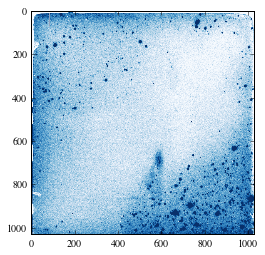

In [4]:
plt.imshow(vlt[0].data[::-1,:], norm=LogNorm(vmin=4000,vmax=4500), cmap=plt.cm.Blues)

### SPIRE data exploration

In [5]:
spire = fits.open(spire500)

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1018: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


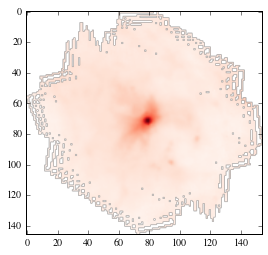

In [6]:
plt.imshow(spire[1].data[::-1,:], 
           norm=LogNorm(vmin=np.nanmin(spire[1].data),vmax=np.nanmax(spire[1].data)), cmap=plt.cm.Reds)

In [7]:
print spire[1].header['NAXIS1']*spire[1].header['CDELT1']*60/11.8, spire[1].header['NAXIS2']*spire[1].header['CDELT2']*60/11.8

-3.04519774011 2.88700564972


In [8]:
print 11.8/60./spire[1].header['CDELT1']

-50.5714285714


In [9]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(spire[1].data, sigma=3.0, iters=10)
print mean, median, std

0.107244732363 0.105414160171 0.0135418049417


### Try to plot them together

In [10]:
from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord('12 01 36.81 -65 08 49.22', unit=(u.hourangle, u.deg))

In [11]:
# shift and zoom-in functions for SPIRE
# design for SPIRE so that I can use the WCS
def scale(hdu_im, shift=(0,0), zoom=1.0, center=None):
    """
    center is the center ra/dec in astropy style
    shift = (y,x)
    """
    import scipy.ndimage.interpolation as interp
#     from astropy import wcs
    
#     w = wcs.WCS(hdu_im.header)
#     if center != None:
#         pix_center = w.wcs_world2pix(center.ra.degree, center.dec.degree, 1)
    
    nx_pix = len(hdu_im.data[:,0])/2
    ny_pix = len(hdu_im.data[0,:])/2
    
    # shift
    im = interp.shift(np.nan_to_num(hdu_im.data), shift)
    
    # zoom-in part
    im = interp.zoom(im, zoom)
    im = im[(len(im[:,0])/2-nx_pix):-nx_pix, (len(im[0,:])/2-ny_pix):-ny_pix]
    

    
    return im
im_scale = scale(spire[1], shift=(20,0), zoom=2)
print np.shape(im_scale)

(146, 154)


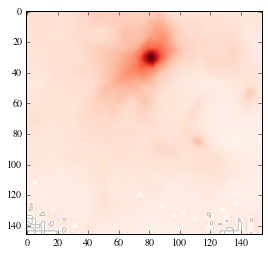

In [12]:
plt.imshow(im_scale[::-1,:], 
           norm=LogNorm(vmin=np.nanmin(spire[1].data),vmax=np.nanmax(spire[1].data)), cmap=plt.cm.Reds)

4.4591494248


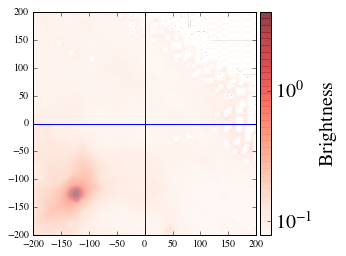

In [17]:
im = plt.imshow(scale(spire[1], shift=(11,11), zoom=50)[::-1,:], 
          norm=LogNorm(vmin=np.nanmin(spire[1].data),vmax=np.nanmax(spire[1].data)),
          cmap=plt.cm.Reds, extent=extent, alpha=0.5)
plt.axvline(0)
plt.axhline(0)
cb = plt.colorbar(im, pad=0.01)
cb.ax.set_ylabel(r'$\rm{Brightness}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)
print np.nanmax(scale(spire[1], shift=(20,25), zoom=5)[::-1,:])

In [16]:
# VLT pointing
vlt_coord = np.array([180.41182, -65.14548])
submm_coord = np.array([180.403375, -65.1470056])
print (vlt_coord-submm_coord)*3600
shift = (vlt_coord-submm_coord)
print shift[0]/spire[1].header['CDELT1'], shift[1]/spire[1].header['CDELT2']

[ 30.402     5.49216]
-2.17157142857 0.392297142856


In [15]:
print np.array([1,2,3,4,5])*std, np.nanmax(spire[1].data[49:99, 52:102])/std

[ 0.0135418   0.02708361  0.04062541  0.05416722  0.06770902] 301.901199491


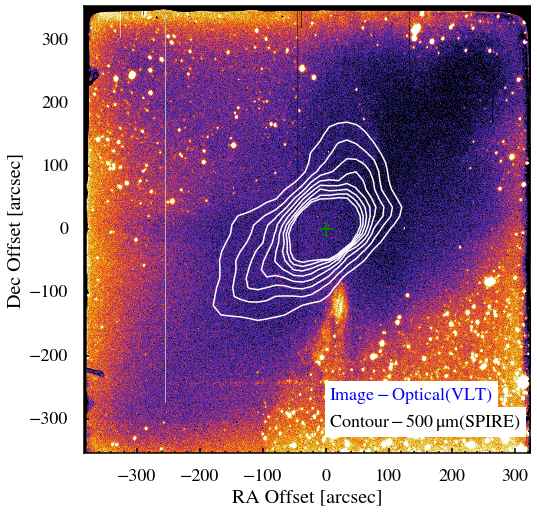

In [69]:
import matplotlib as mpl
mpl.rcParams['contour.negative_linestyle'] = 'solid'

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

vlt_size = 11.8 * 60
extent = -vlt_size/2-30, vlt_size/2-30, -vlt_size/2, vlt_size/2

ax.imshow(vlt[0].data[::-1,:], norm=LogNorm(vmin=4000,vmax=4500), cmap=plt.cm.CMRmap, extent=extent)
levels = np.log10(np.linspace(2, 5, 8)*mean)
ax.contour(np.log10(spire[1].data[49:99, 52:102]), levels=levels, vmin=std,
            colors='w', linestyle='-', origin='lower', extent=extent, extend='neither', linewidths=1.5)
# ax.imshow(scale(spire[1], shift=(20,25), zoom=5)[::-1,:], 
#           norm=LogNorm(vmin=np.nanmin(spire[1].data),vmax=np.nanmax(spire[1].data)),
#           cmap=plt.cm.Reds, extent=extent, alpha=0.5)
ax.plot([0],[0], '+', color='g', markersize=15, markeredgewidth=2)

ax.text(0.55,0.12,r'$\rm{Image-Optical(VLT)}$', fontsize=18,transform=ax.transAxes, color='b', backgroundcolor='w')
ax.text(0.55,0.06,r'$\rm{Contour-500\,\mu m(SPIRE)}$', fontsize=18,transform=ax.transAxes, color='k', backgroundcolor='w')

ax.set_xlabel('RA Offset [arcsec]', fontsize=20)
ax.set_ylabel('Dec Offset [arcsec]', fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/test/vlt_spire.pdf', format='pdf', dpi=300, bbox_inches='tight')